In [2]:
import geopandas
from collections import Counter
from shapely import geometry
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon, box
from pandas.core.frame import DataFrame
import sqlite3
from sqlite3 import connect
from sklearn.model_selection import train_test_split

##### Counties in WI

In [3]:
data=geopandas.read_file('counties.geojson')
r_list=list(set(list(data['NAME'])))
r_list

['Milwaukee County',
 'Green County',
 'Manitowoc County',
 'Pierce County',
 'Menominee County',
 'Barron County',
 'Kewaunee County',
 'Lincoln County',
 'Richland County',
 'Price County',
 'Ashland County',
 'Trempealeau County',
 'Taylor County',
 'Door County',
 'Langlade County',
 'Outagamie County',
 'Monroe County',
 'Calumet County',
 'Grant County',
 'Oneida County',
 'Marquette County',
 'Waushara County',
 'Adams County',
 'La Crosse County',
 'Racine County',
 'Wood County',
 'Dunn County',
 'Sauk County',
 'Forest County',
 'Green Lake County',
 'Florence County',
 'Walworth County',
 'Crawford County',
 'Buffalo County',
 'Portage County',
 'Dodge County',
 'Bayfield County',
 'St. Croix County',
 'Winnebago County',
 'Shawano County',
 'Ozaukee County',
 'Rock County',
 'Waupaca County',
 'Sheboygan County',
 'Vilas County',
 'Columbia County',
 'Fond du Lac County',
 'Marathon County',
 'Oconto County',
 'Jackson County',
 'Kenosha County',
 'Juneau County',
 'Sawyer 

##### Population in each county

<AxesSubplot:>

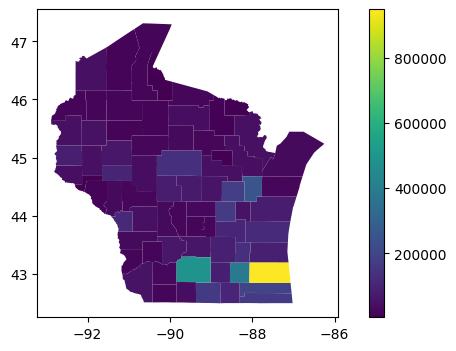

In [4]:
pop100=geopandas.GeoDataFrame(data['POP100'].to_frame())
ax=data.plot(figsize=(8,4),column="POP100",legend=True, cmap="viridis")
ax

In [5]:
connection=sqlite3.connect("counties_tracts.db")
data["AREALAND"]=pd.read_sql("""SELECT * FROM counties """,connection)["AREALAND"]

In [6]:
pd.read_sql("""SELECT * FROM sqlite_master""", connection)

,type,name,tbl_name,rootpage,sql
0,table,counties,counties,2,"CREATE TABLE ""counties"" (\n""index"" INTEGER,\n ..."
1,index,ix_counties_index,counties,3,"CREATE INDEX ""ix_counties_index""ON ""counties"" ..."
2,table,tracts,tracts,4,"CREATE TABLE ""tracts"" (\n""index"" INTEGER,\n ""..."
3,index,ix_tracts_index,tracts,5,"CREATE INDEX ""ix_tracts_index""ON ""tracts"" (""in..."


In [7]:
data_train, data_test = \
train_test_split(data, random_state=250,test_size=0.25)

##### Counties in test dataset

In [8]:
list(data_test['NAME'])

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

##### How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?

In [9]:
from sklearn.linear_model import LinearRegression
data1=data.values
model1= LinearRegression()
x=data["AREALAND"]
y=data["POP100"]
x_train, x_test, y_train, y_test = \
train_test_split(x, y, random_state=250,test_size=0.25)
xtrain=x_train.values.reshape(-1,1)
xtest=x_test.values.reshape(-1,1)
ytrain=y_train.values
ytest=y_test.values
model1.fit(xtrain, ytrain)
model1.score(xtest, ytest)

0.016720430179409274

##### The predicted population of a county with 400 square miles of area, according to the model?

In [10]:
import pandas as pd
x=pd.DataFrame({"POP":[400*1000*1000*2.59]})
model1.predict(x.values.reshape(-1,1))[0]

90000.07422783462

##### What are the counties in the test dataset? (model2, adding housing units as to the geopandas dataframe)

In [11]:
df_HU100=pd.read_sql("""SELECT counties.*, sum(HU100) AS HU100 FROM counties
INNER JOIN tracts
ON tracts.COUNTY = counties.COUNTY
GROUP BY counties.COUNTY
""",connection).sort_values(by="index")
data["HU100"]=df_HU100["HU100"].to_list()
data2=data.values
model2= LinearRegression()
x=data["HU100"]
y=data["POP100"]
x_train, x_test, y_train, y_test = \
train_test_split(x, y, random_state=250,test_size=0.25)
hu100_test_name=data.loc[x_test.keys(),:]["NAME"].to_list()
#hu100_test_county=data.loc[x_test.keys(),:]["COUNTY"].to_list()
hu100_test_name

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

#####  The Housing Unit values for the counties in the test dataset

In [13]:
df_select=data.loc[x_test.keys(),:]
county_hu100={}
for index in range(len(hu100_test_name)):
    county_hu100[df_select["NAME"].to_list()[index]]=df_select["HU100"].to_list()[index]
county_hu100

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

##### How much variance in the POP100 can a LinearRegression model explain based only on HU100?

In [14]:
from sklearn.model_selection import cross_val_score
data["HU100"]=df_HU100["HU100"].to_list()
data2=data.values
model2= LinearRegression()
x_train, x_test, y_train, y_test = \
train_test_split(x, y, random_state=250,test_size=0.25)
xtrain=x_train.values.reshape(-1,1)
ytrain=y_train.values
model2.fit(xtrain, ytrain)
mean_value=sum(cross_val_score(model2, xtrain, ytrain))/len(cross_val_score(model2, xtrain, ytrain))
mean_value

0.9739348181232653

##### The standard deviation of the cross validation scores of the model

In [15]:
import math
math.sqrt(sum((cross_val_score(model2, xtrain, ytrain)-mean_value)**2)/len(cross_val_score(model2, xtrain, ytrain)))

0.01693954236334351

##### The formula relating POP100 and HU100

In [16]:
coef=round(model2.coef_[0],2)
intercept=round(model2.intercept_,2)
r'POP100 = {}*HU100 + {}'.format(coef,intercept)

'POP100 = 2.47*HU100 + -9276.89'

##### The relationship between HU100 and POP100

/home/surface/.local/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


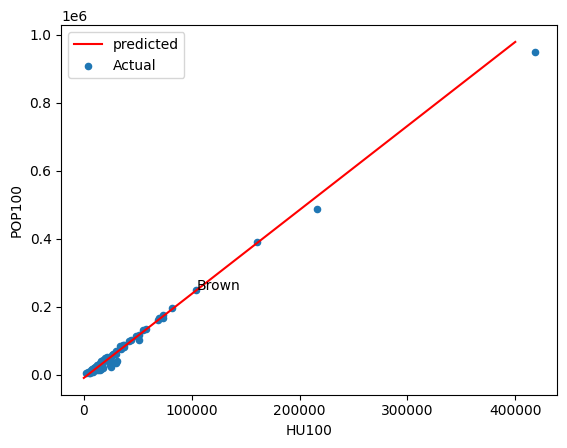

In [15]:
predict_df=pd.DataFrame({"POP100":range(0,500000,100000)})
predict_df["predicted"]=model2.predict(predict_df)
ax=predict_df.plot.line(x="POP100",y="predicted",color="r")
brown=data[data["NAME"]=="Brown County"]
x=brown["HU100"].to_list()[0]
y=brown["POP100"].to_list()[0]
data.plot.scatter(x="HU100",y="POP100",ax=ax).text(x,y,"Brown")
ax.legend(["predicted","Actual"])

In [17]:
import numpy as np
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

len(A[np.logical_and(A>=3 ,A<=6)])

8

In [17]:
from matplotlib.colors import ListedColormap

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

##### How does Brown County look

In [ ]:
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
land = rasterio.open("zip://../p6/land.zip!wi.tif")
data_brown=data[data["NAME"]=="Brown County"].to_crs(land.crs)["geometry"]
matrix, _ = mask(land, data_brown, crop=True)
matrix = matrix[0]
fig,ax=plt.subplots(figsize=(6,6))
ax.imshow(matrix, vmin=0, vmax=255,cmap=custom_cmap)

In [ ]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

##### The portion of Brown County is "Open Water"

##### The portion of Brown County is "Open Water"

In [20]:
water=(matrix==11).astype(int).sum()
total=(matrix!=0).astype(int).sum()
water/total

0.13797526789725206

In [21]:
pop=data["POP100"].to_list()
all_matrix=[]
for i in data["NAME"].to_list(): 
    data_brown=data[data["NAME"]==i].to_crs(land.crs)["geometry"]
    matrix, _ = mask(land, data_brown, crop=True)
    matrix = matrix[0]
    water=(matrix==11).astype(int).sum()
    total=(matrix!=0).astype(int).sum()
    proportion=water/total
    all_matrix.append(proportion)

<AxesSubplot:xlabel='Open Water In County', ylabel='POP'>

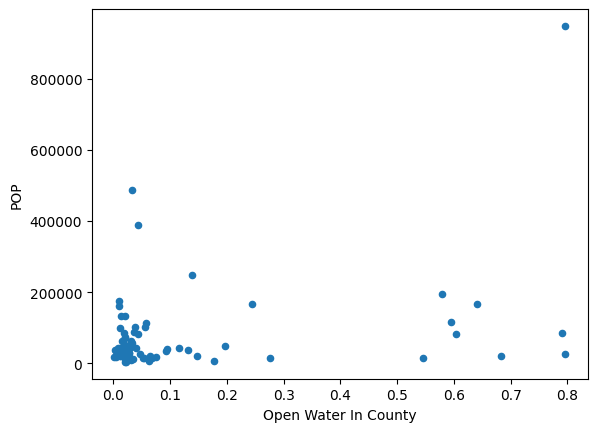

In [22]:
dict_={"Open Water In County":all_matrix,"POP":pop}
df=DataFrame(dict_)
df.plot.scatter(x="Open Water In County", y="POP")

"The graph shows the coefficients of each key predicting the population. The 'developed_med' and 'developed_low' have two of the largest value of coefficients, which means that they have the most significant effect when they have some change. Thus, I choose the two factors."

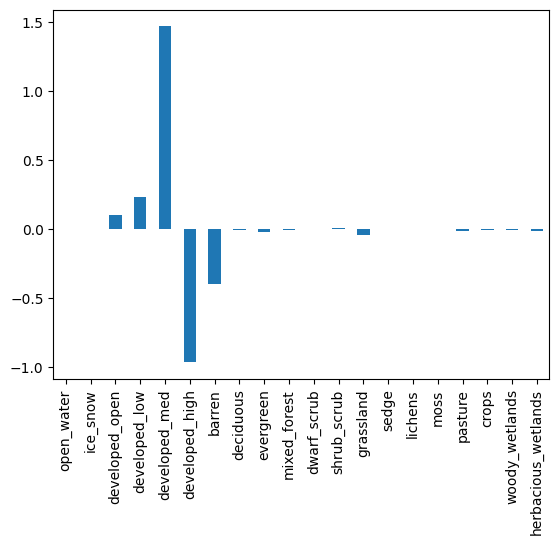

In [23]:
#q16
shp_df = geopandas.read_file("tracts.shp")
geometry_value=shp_df.to_crs(land.crs)['geometry']
feature_name=list(land_use.keys())
feature_value=list(land_use.values())
length=len(geometry_value)
element_=[]
for i in range(length):
    matrix, _ = mask(land,geometry_value[i:i+1], crop=True)
    matrix = matrix[0]
    value_list=[]
    for x in feature_value:
        item_value=(matrix==x).astype(int).sum()
        value_list.append(item_value) 
    element_.append(value_list)  
model3=LinearRegression()
pd_element=pd.DataFrame.from_dict(element_)
pd_element.columns=feature_value
target=shp_df["POP100"]
x_train, x_test, y_train, y_test = \
train_test_split(pd_element, target, random_state=320)
#model3.fit(xtrain, ytrain)
model3.fit(x_train, y_train)
pd.Series(model3.coef_,index=feature_name).plot.bar()

r"The graph shows the coefficients of each key predicting the population. The 'developed_med' and 'developed_low' have two of the largest value of coefficients, which means that they have the most significant effect when they have some change. Thus, I choose the two factors."

In [24]:
#q17
model4=LinearRegression()
data_model1=pd_element[land_use["developed_med"]]
target1=shp_df["POP100"]
x_train, x_test, y_train, y_test = \
train_test_split(data_model1, target1, random_state=320)
xtrain=x_train.values.reshape(-1,1)
xtest=x_test.values.reshape(-1,1)
ytrain=y_train.values
ytest=y_test.values
model4.fit(xtrain, ytrain)
#model4.score(xtest,ytest)


model5=LinearRegression()
data_model2=pd_element[land_use["developed_low"]]
target1=shp_df["POP100"]
x_train, x_test, y_train, y_test = \
train_test_split(data_model2, target1, random_state=320)
xtrain=x_train.values.reshape(-1,1)
xtest=x_test.values.reshape(-1,1)
ytrain=y_train.values
ytest=y_test.values
model5.fit(xtrain, ytrain)
#model5.score(xtest,ytest)

model1_scores = cross_val_score(model4, data_model1.values.reshape(-1,1), target1.values)
model2_scores = cross_val_score(model5, data_model2.values.reshape(-1,1), target1.values)
err = pd.Series({"model1": model1_scores.var(),
                   "model2": model2_scores.var(),})
means = pd.Series({"model1": model1_scores.mean(),
                   "model2": model2_scores.mean(),})
r"The first model which uses the only factor 'developed_med' is the recommending model, since it has a higher score, so it is more effective to predict the population; and there is one factor, so it is very simple, and we do not need to spend too much gathering information; and the variance of the model is 0.002435225104, which is less than the other model."
means.max()

0.37114697558542503